In [1]:
%matplotlib widget
import numpy as np
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from textwrap import wrap

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
import warnings
warnings.filterwarnings('ignore')

# Load data 

[45]
1 scan(s), 106768 total on/off shots


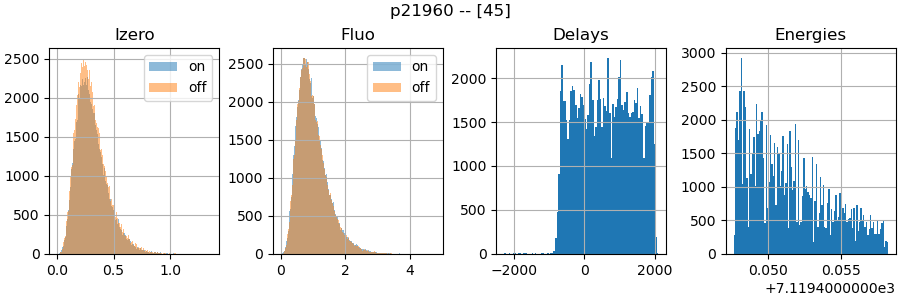

Time delay axis rebinned with TT data


In [2]:
pgroup = 'p21960'
Loaddir_name = ''

average_twodiodes = True
withTT    = True

#runlist = np.arange(45, 47)
runlist = [45]

##############################################

Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
#firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
firstrun = glob.glob('/sf/alvra/data/{}/work/testdata/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist, average_twodiodes)

globals().update(data)
print (runlist)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(pump_1)))

Plot_reduced_data(pgroup, runlist, scan, data, withTT, timescan=True)

pump_1       = np.asarray(pump_1)
unpump_1     = np.asarray(unpump_1)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
energy       = np.asarray(energy)
Delays_corr  = np.asarray(Delays_corr)

## [Average scans](#Averaged-scans)
## [Overlay curves](#Overlay-data)

# Averaged scans

Time delay axis rebinned with delay stage data
86832 shots out of 87196 survived (total shots: 106768)


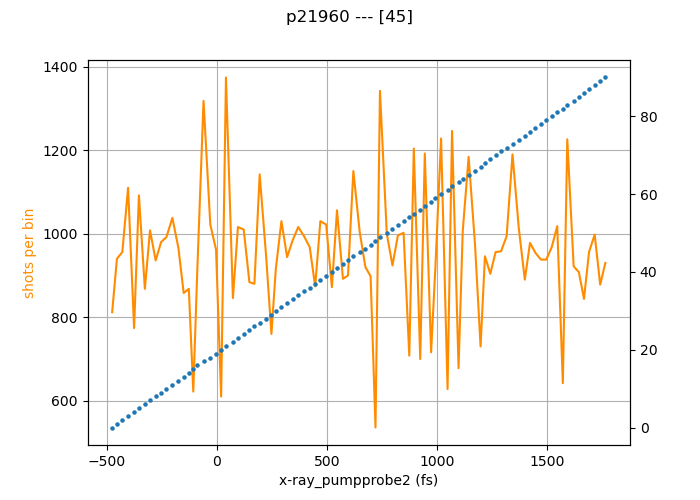

In [13]:
quantile = 1

binsize = 25
min_delay = -500
max_delay = 1800

variable_bins=False
numbins=25

####################################################################
####################################################################

pp_TT, err_pp, Delay_fs_TT, howmany = \
Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, withTT, numbins, variable_bins)

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(Delay_fs_TT), 1)
ax1.plot(Delay_fs_TT, howmany, color = 'darkorange')
ax2.scatter(Delay_fs_TT, delayrange, s = 5)

ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()


Width = 102.8868 fs
t0 = -8.9777 fs


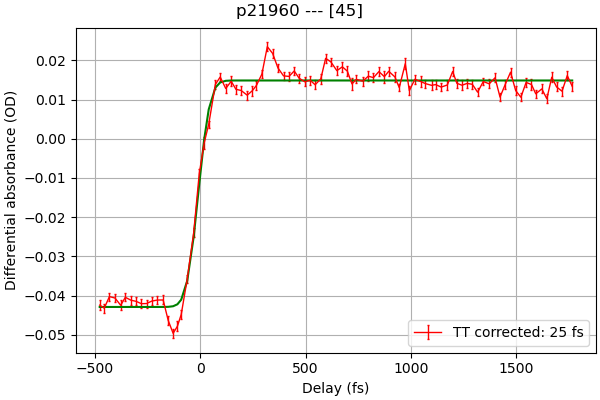

In [14]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(6,4))
plt.suptitle(titlestring_stack)

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected: {} fs'.format(binsize))
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    #fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,0)

    #p0 = [-100, 100, 0, 200, 0]
    #popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    #pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    # t0_fs = popt[0]
    # width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))
    print("t0 = {:.4f} fs".format(t0_fs))
plt.grid()
plt.ylabel('Differential absorbance (OD)')
plt.xlabel('Delay (fs)')
plt.show()

# Fit risetime

In [6]:
from lmfit.models import PseudoVoigtModel

pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)

mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=500, center= 0, sigma=1, fraction=0.5, x=Delay_fs_TT)

pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 20, 0])

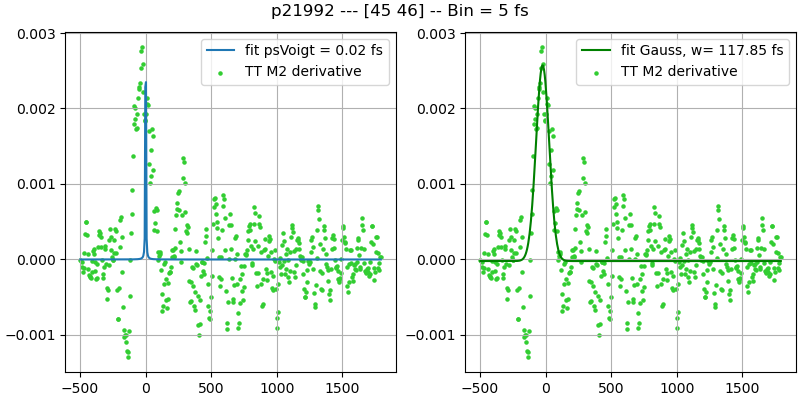

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
fig.suptitle(titlestring_stack + ' -- Bin = {} fs'.format(binsize))
ax1.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax1.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit psVoigt = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
ax1.grid()
ax1.legend(loc='upper right')

ax2.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax2.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'fit Gauss, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

ax2.legend(loc='upper right')
ax2.grid()
plt.show()

# FFT

114
(345,) (345,)


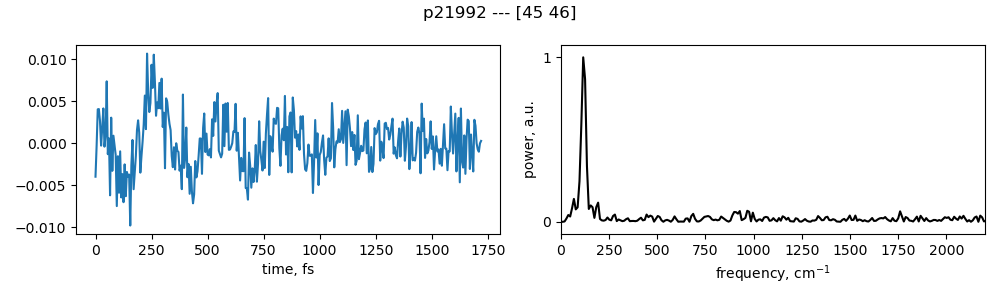

In [8]:
chosen_point = 70
index_point = np.int(np.argwhere(Delay_fs_TT > chosen_point)[0])
print (index_point)

transient = pp_TT[index_point:]
x = Delay_fs_TT[index_point:]
fit = pp_fit[index_point:]

print(np.shape(transient), np.shape(x))
fitoutput = np.poly1d(np.polyfit(x, transient, 3))
pows = fitoutput(x)
transient2 = transient-pows
#transient2 = transient-fit

                
vals = np.hstack((transient2, np.zeros_like(transient2))) # pad
power = np.abs(np.fft.fft(vals))**2
frequencies = np.arange(0,0.999999999,1/len(vals))*16678*(2/binsize)

plt.figure(figsize=(10,3))
plt.suptitle(titlestring_stack)
plt.subplot(121)
#plt.plot(np.arange(0, binsize*len(transient), binsize), transient)
plt.plot(np.arange(0, binsize*len(transient), binsize), transient2, '-')
plt.xlabel('time, fs')

plt.subplot(122)
plt.plot(frequencies,power/np.max(power), '-', color='black')
plt.xlim(0,2200)
plt.xlabel('frequency, cm$^{-1}$')
plt.ylabel('power, a.u.')
plt.yticks([0,1])
plt.ylim(-0.075, 1.075)
#plt.vlines(1647, -0.1, 1.1, color='lightgrey', linestyle='dashed')
plt.tight_layout()

plt.show()
PNG_dir = '/sf/alvra/data/p21992/work/PNG/'
os.makedirs(PNG_dir, exist_ok=True)
plt.savefig(PNG_dir+'FePhen_XANES_FFT.png')

# Fit decay constants

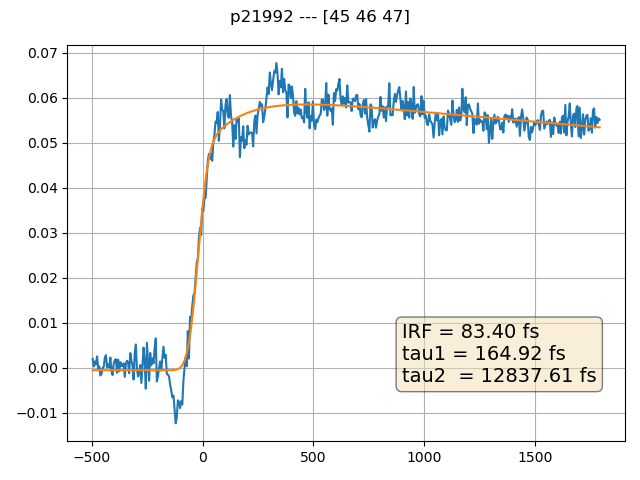

In [31]:
###################### 1 exp #################################
###   x0, sigma, amp1, tau1, C
p0 = [0,  100,   1,    1000, 1]
popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_1exp(Delay_fs_TT, *popt)

###################### 2 exp #################################
###   x0, sigma, amp1, tau1, C, amp2, tau2
p0 = [0,  200,   1,    1000, 1, 1,    10000]
popt,_  = curve_fit(model_decay_2exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_2exp(Delay_fs_TT, *popt)

###############################################################
fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(Delay_fs_TT, pp_TT)
plt.plot(Delay_fs_TT, y_fit)

popt = np.pad(popt, (0, 7-len(popt)), 'constant', constant_values=np.nan)
boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'IRF = {:.2f} fs'.format(np.abs(popt[1]*2.3548)),
                     r'tau1 = {:.2f} fs'.format(np.abs(popt[3])),
                     r'tau2  = {:.2f} fs'.format(np.abs(popt[6]))))
plt.text(0.6, 0.15, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.grid()
plt.tight_layout()
#plt.ylim(-0.25, 2)
plt.show()

#os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/{}.png'.format(ROI.split(':')[-1]))

## Overlay data

In [9]:
pgroup = 'p21992'

#unlist = np.arange(104, 117)

runlist = np.arange(45, 47)
Loaddir_folder = ''

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [45 46] from /sf/alvra/data/p21992/work/Reduced_data//


['/sf/alvra/data/p21992/work/Reduced_data/run0045-FePhen_Timescan_7119p5eV_001/run_array.npy',
 '/sf/alvra/data/p21992/work/Reduced_data/run0046-FePhen_Timescan_7119p5eV_002/run_array.npy']

Time delay axis rebinned with TT data
42351 shots out of 87218 survived (total shots: 106768)
Time delay axis rebinned with TT data
42653 shots out of 87940 survived (total shots: 106826)


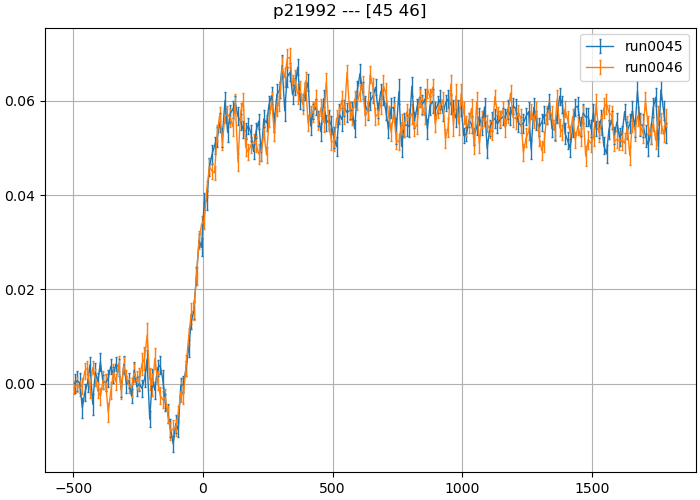

In [12]:
quantile = 0.7
twodiodes = True

withTT = True

binsize = 10
min_delay = -500
max_delay = 1800

variable_bins=False
numbins=100

####################################################

fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    runname = 'run{:04d}'.format(run)
    data = {}
    data, _ = load_reduced_data(pgroup, Loaddir, [run], twodiodes)
    globals().update(data)
    
    pp_TT, err_pp, Delay_fs_TT,_ = \
    Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, withTT)#numbins, variable_bins)
    
    ax1.errorbar(Delay_fs_TT, pp_TT, err_pp, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+' '+str(lab[index]))
ax1.legend()
ax1.grid()


## save the averaged spectra to load them overlaid

In [104]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Reduced_data/Timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

run_array = {}
run_array[run_name.split('-')[0]] = {"name": run_name,
                                    "Pump_probe_Diode1": pp_TT, 
                                    "errbars_pp": err_pp,
                                    "Delay_fs": Delay_fs_TT
                                    }
np.save(reducedir+run_name+'/run_array', run_array)

In [ ]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_1diode(reducedir, run_name, scan, 
                         average_array(DataDiode1_pump, 0), 
                         average_array(DataDiode1_unpump, 0), 
                         average_array(Pump_probe_Diode1, 0), 
                         average_array(goodshots1, 0),
                         average_array(correlation1, 0))
print (reducedir+run_name)

## save the averaged spectra to load them overlaid

In [7]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_2diodes(reducedir, run_name, scan, 
                          average_array(DataDiode1_pump, 0), 
                          average_array(DataDiode1_unpump, 0), 
                          average_array(Pump_probe_Diode1, 0), 
                          average_array(goodshots1, 0), 
                          average_array(correlation1, 0),
                          average_array(DataDiode2_pump, 0), 
                          average_array(DataDiode2_unpump, 0), 
                          average_array(Pump_probe_Diode2, 0), 
                          average_array(goodshots2, 0),
                          average_array(correlation2, 0))
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001
